In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
!pip install gdown
!pip install tensorflow-gpu

  Installing build dependencies ... |^C
anceled
ERROR: Operation cancelled by user
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [153]:
df = pd.read_csv('../personal/7ODM.csv')
#df.columns = ['date', 'un', 'ue', 'uz', 'sn', 'se', 'sz']
df= df[['yyyy.yyyy', '__east(m)']]
df.columns = ['date', 'un']
df.set_index('date', inplace=True)
df.head()

,un
date,
2001.3005,0.084091
2001.3032,0.086470
2001.3060,0.087425
2001.4209,0.080423
2001.4237,0.081143


In [154]:
type(df.index[0])

numpy.float64

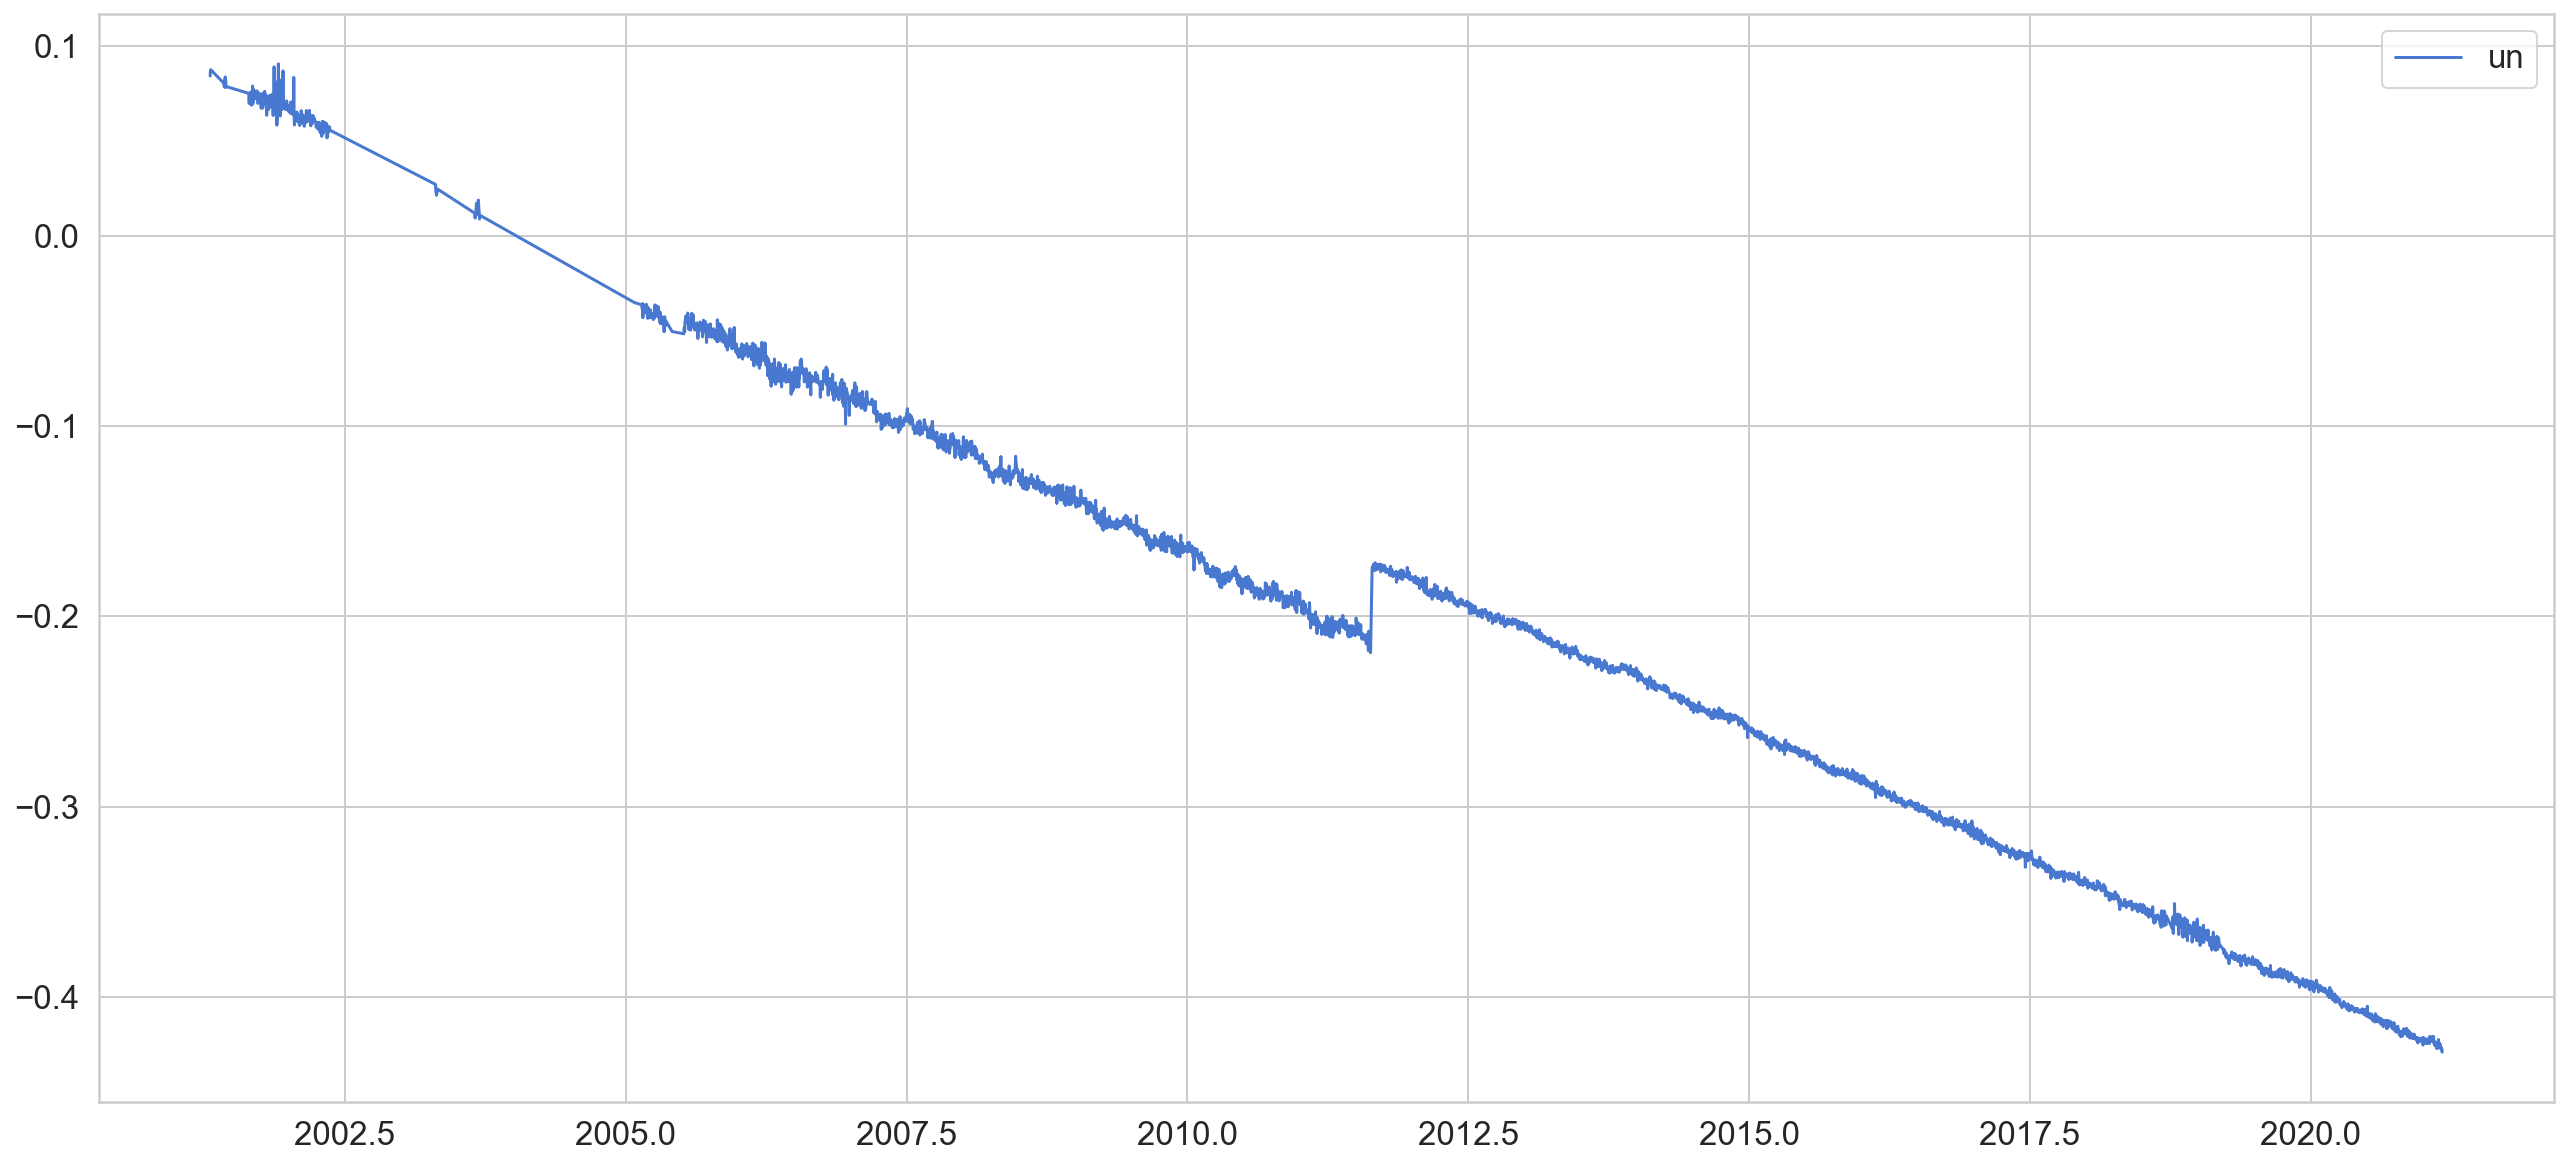

In [155]:
plt.plot(df, label='un')
plt.legend();

In [156]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(5634, 1) (297, 1)


In [157]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['un']])

train['un'] = scaler.transform(train[['un']])
test['un'] = scaler.transform(test[['un']])

/var/folders/lv/0w01hdjd20g_v4q9k2bpnpgm0000gn/T/ipykernel_3010/4053733303.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['un'] = scaler.transform(train[['un']])
/var/folders/lv/0w01hdjd20g_v4q9k2bpnpgm0000gn/T/ipykernel_3010/4053733303.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['un'] = scaler.transform(test[['un']])


In [158]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [159]:
TIME_STEPS = 20

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['un']], train.un, TIME_STEPS)
X_test, y_test = create_dataset(test[['un']], test.un, TIME_STEPS)

print(X_train.shape)

(5614, 20, 1)


In [160]:
test

,un
date,
2020.3587,-1.759640
2020.3614,-1.744217
2020.3641,-1.754020
2020.3669,-1.756120
2020.3696,-1.749088
...,...
2021.1581,-1.942919
2021.1608,-1.937351
2021.1636,-1.942423


In [161]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [162]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30


2022-07-08 12:47:48.221081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-08 12:47:48.398263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-08 12:47:48.442444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-08 12:47:48.513721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-08 12:47:48.598231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


158/158 [==============================] - ETA: 0s - loss: 0.1934

2022-07-08 12:47:51.772526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-08 12:47:51.836286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-08 12:47:51.874870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


158/158 [==============================] - 5s 22ms/step - loss: 0.1934 - val_loss: 0.1852
Epoch 2/30
158/158 [==============================] - 3s 17ms/step - loss: 0.1383 - val_loss: 0.1252
Epoch 3/30
158/158 [==============================] - 3s 18ms/step - loss: 0.1251 - val_loss: 0.0882
Epoch 4/30
158/158 [==============================] - 3s 18ms/step - loss: 0.1091 - val_loss: 0.0802
Epoch 5/30
158/158 [==============================] - 3s 18ms/step - loss: 0.0959 - val_loss: 0.0709
Epoch 6/30
158/158 [==============================] - 3s 18ms/step - loss: 0.0797 - val_loss: 0.0821
Epoch 7/30
158/158 [==============================] - 3s 17ms/step - loss: 0.0708 - val_loss: 0.0848
Epoch 8/30
158/158 [==============================] - 3s 18ms/step - loss: 0.0540 - val_loss: 0.0903
Epoch 9/30
158/158 [==============================] - 3s 18ms/step - loss: 0.0473 - val_loss: 0.0899
Epoch 10/30
158/158 [==============================] - 3s 18ms/step - loss: 0.0520 - val_loss: 0.1030


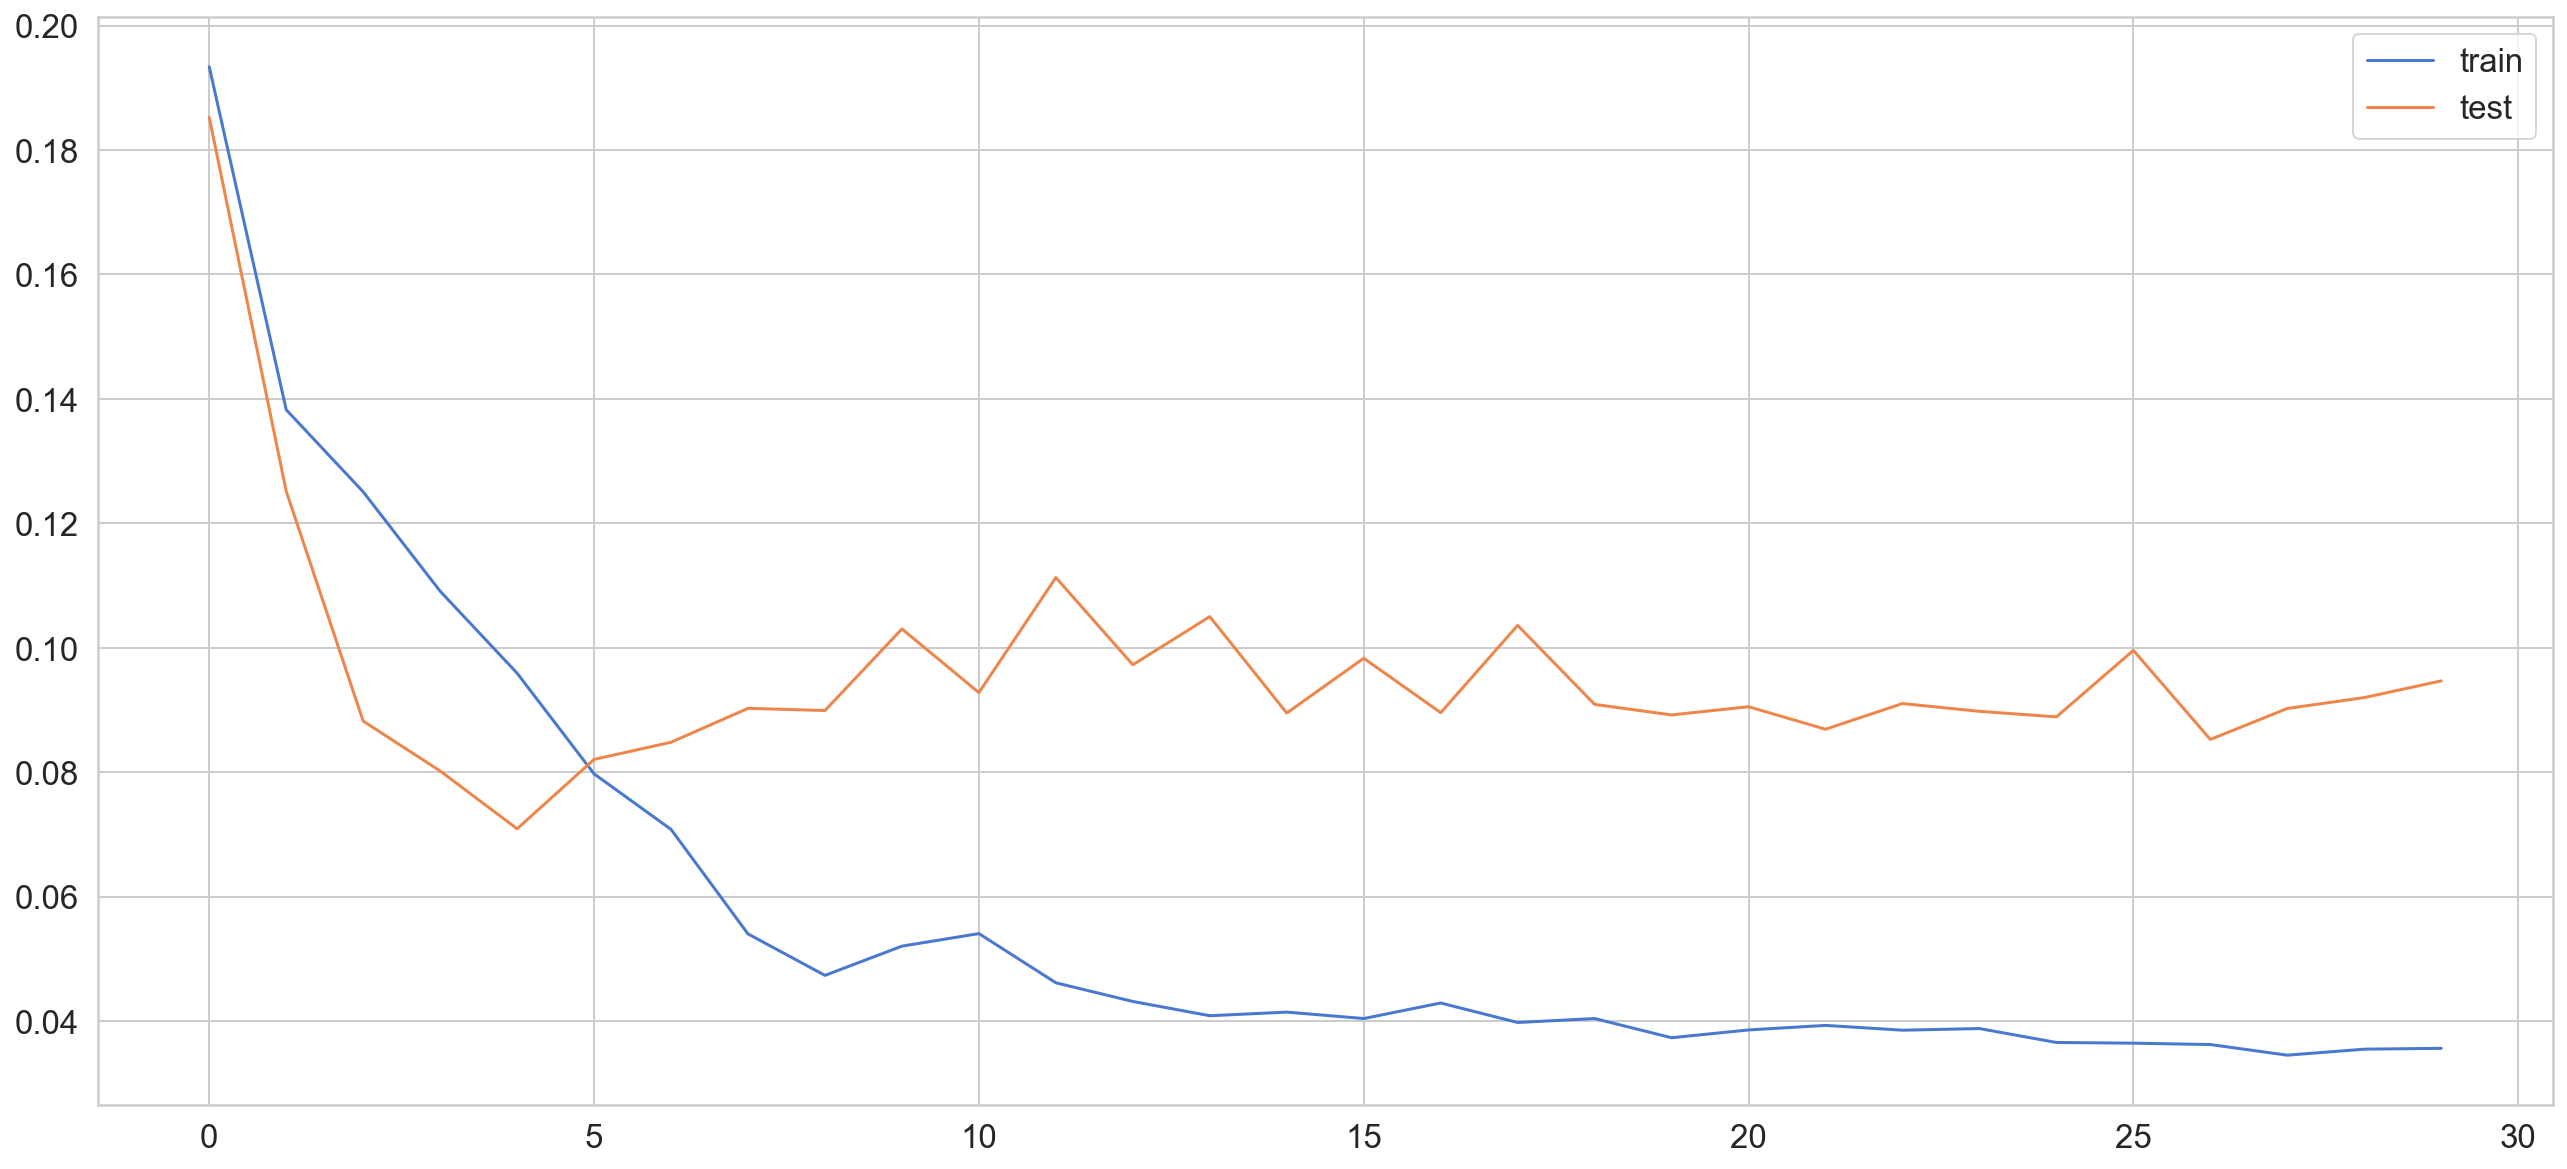

In [163]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [164]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

  9/176 [>.............................] - ETA: 1s  

2022-07-08 12:49:13.390487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-08 12:49:13.450625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-08 12:49:13.489274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


176/176 [==============================] - 2s 7ms/step


/Users/nikilshyamsunder/miniforge3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


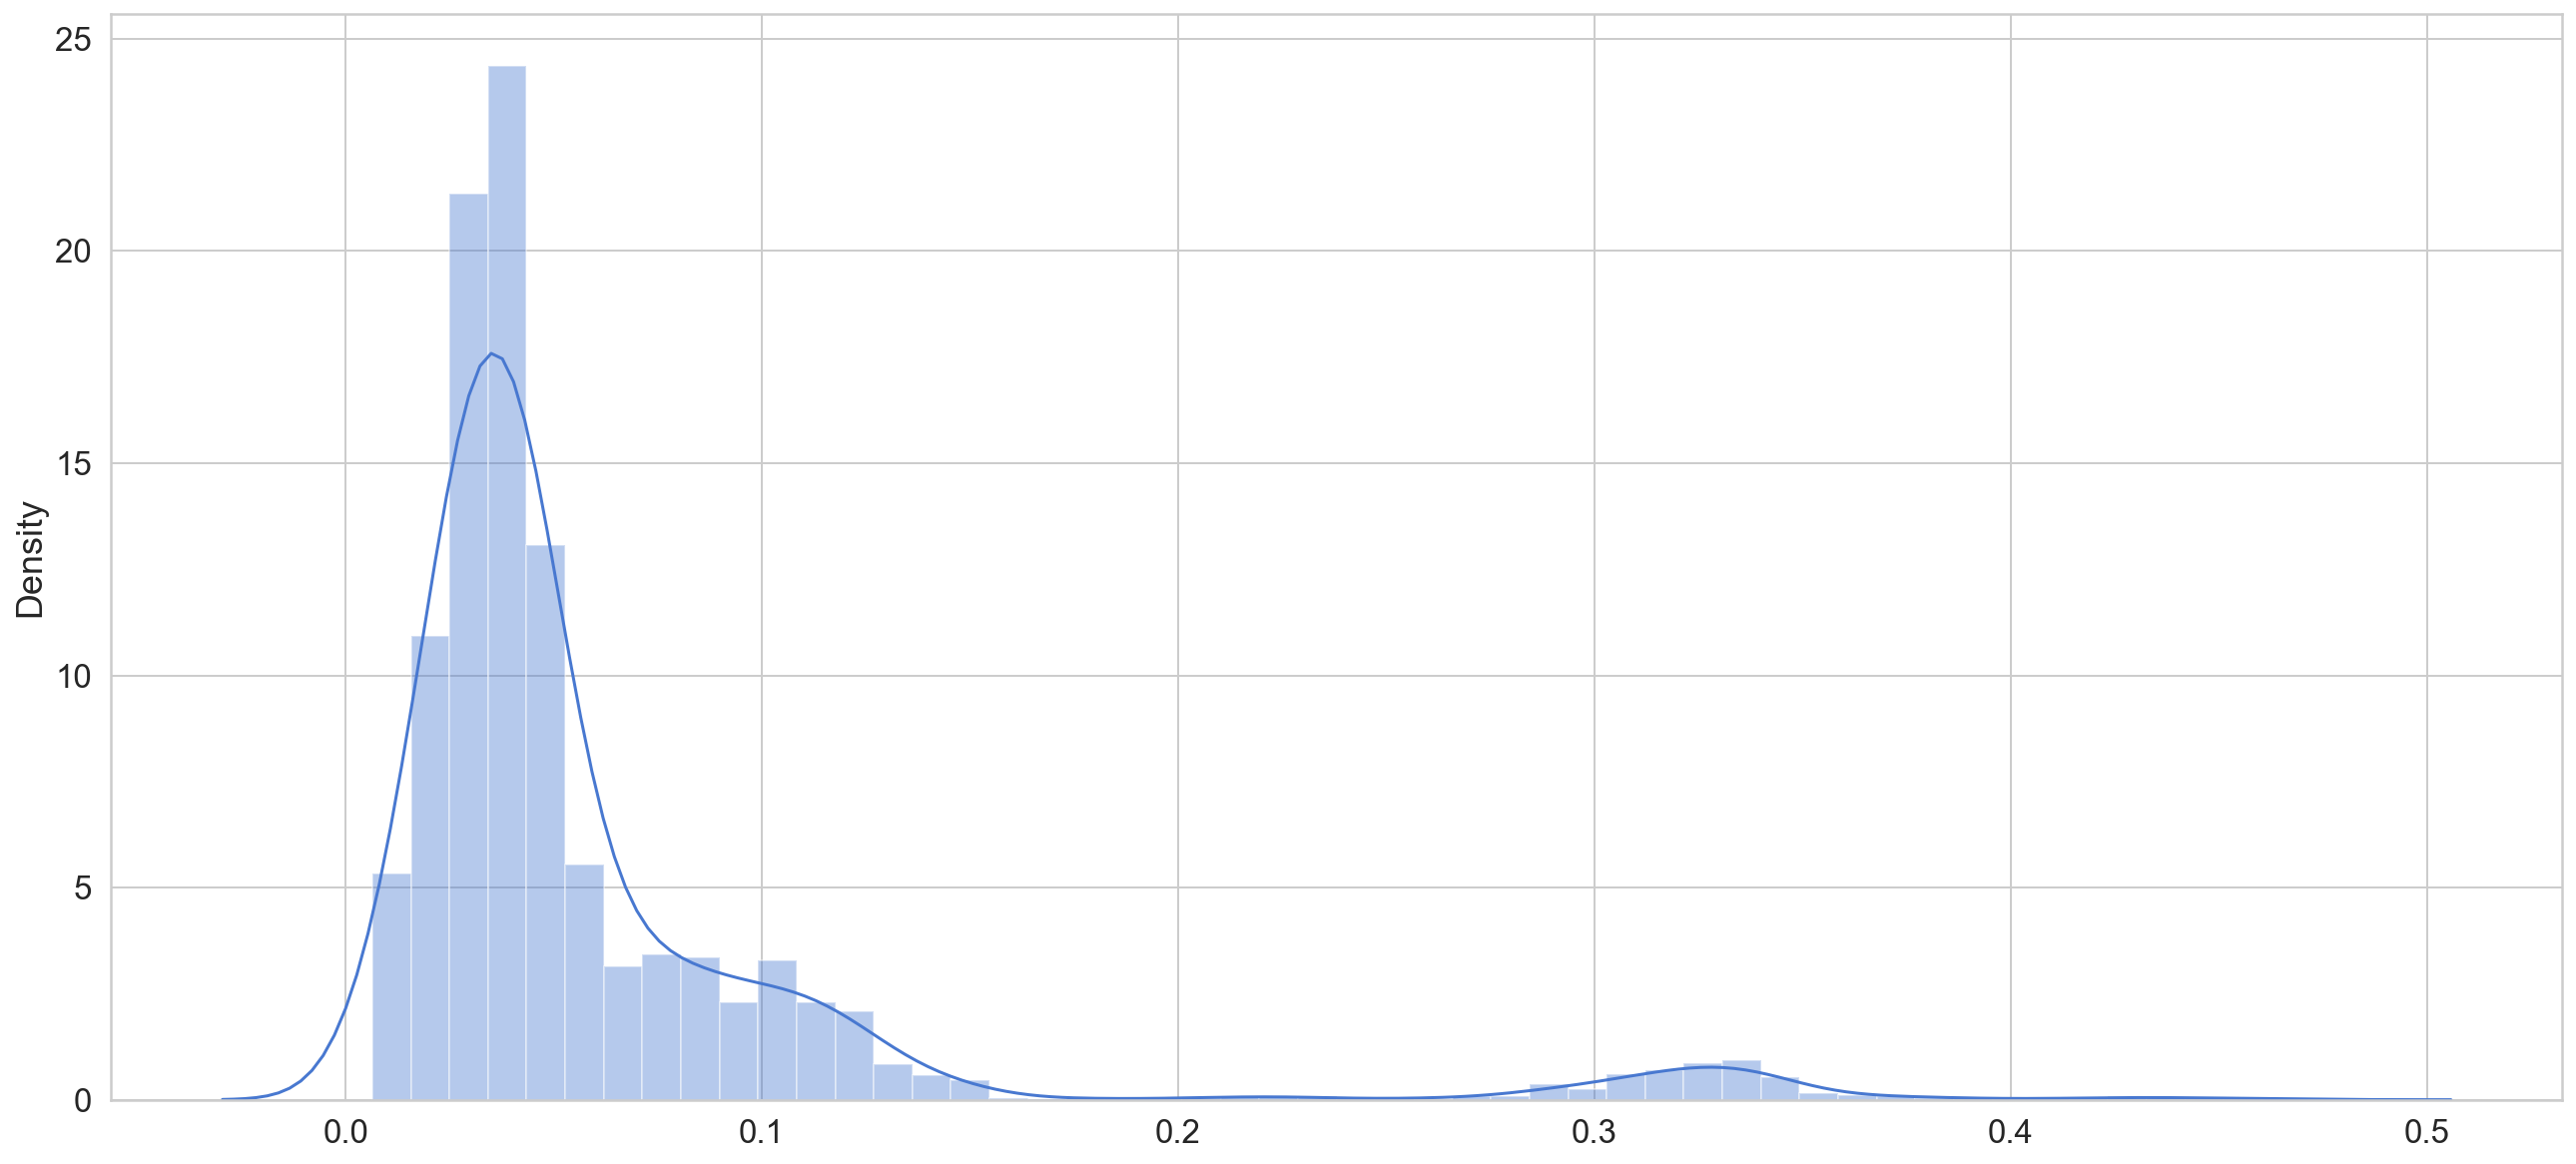

In [165]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [166]:
THRESHOLD = .2

train_score_df = pd.DataFrame(index=train.iloc[TIME_STEPS:].index)
train_score_df['loss'] = train_mae_loss
train_score_df['threshold'] = THRESHOLD
train_score_df['anomaly'] = train_score_df.loss > train_score_df.threshold
train_score_df['un'] = train.iloc[TIME_STEPS:].un

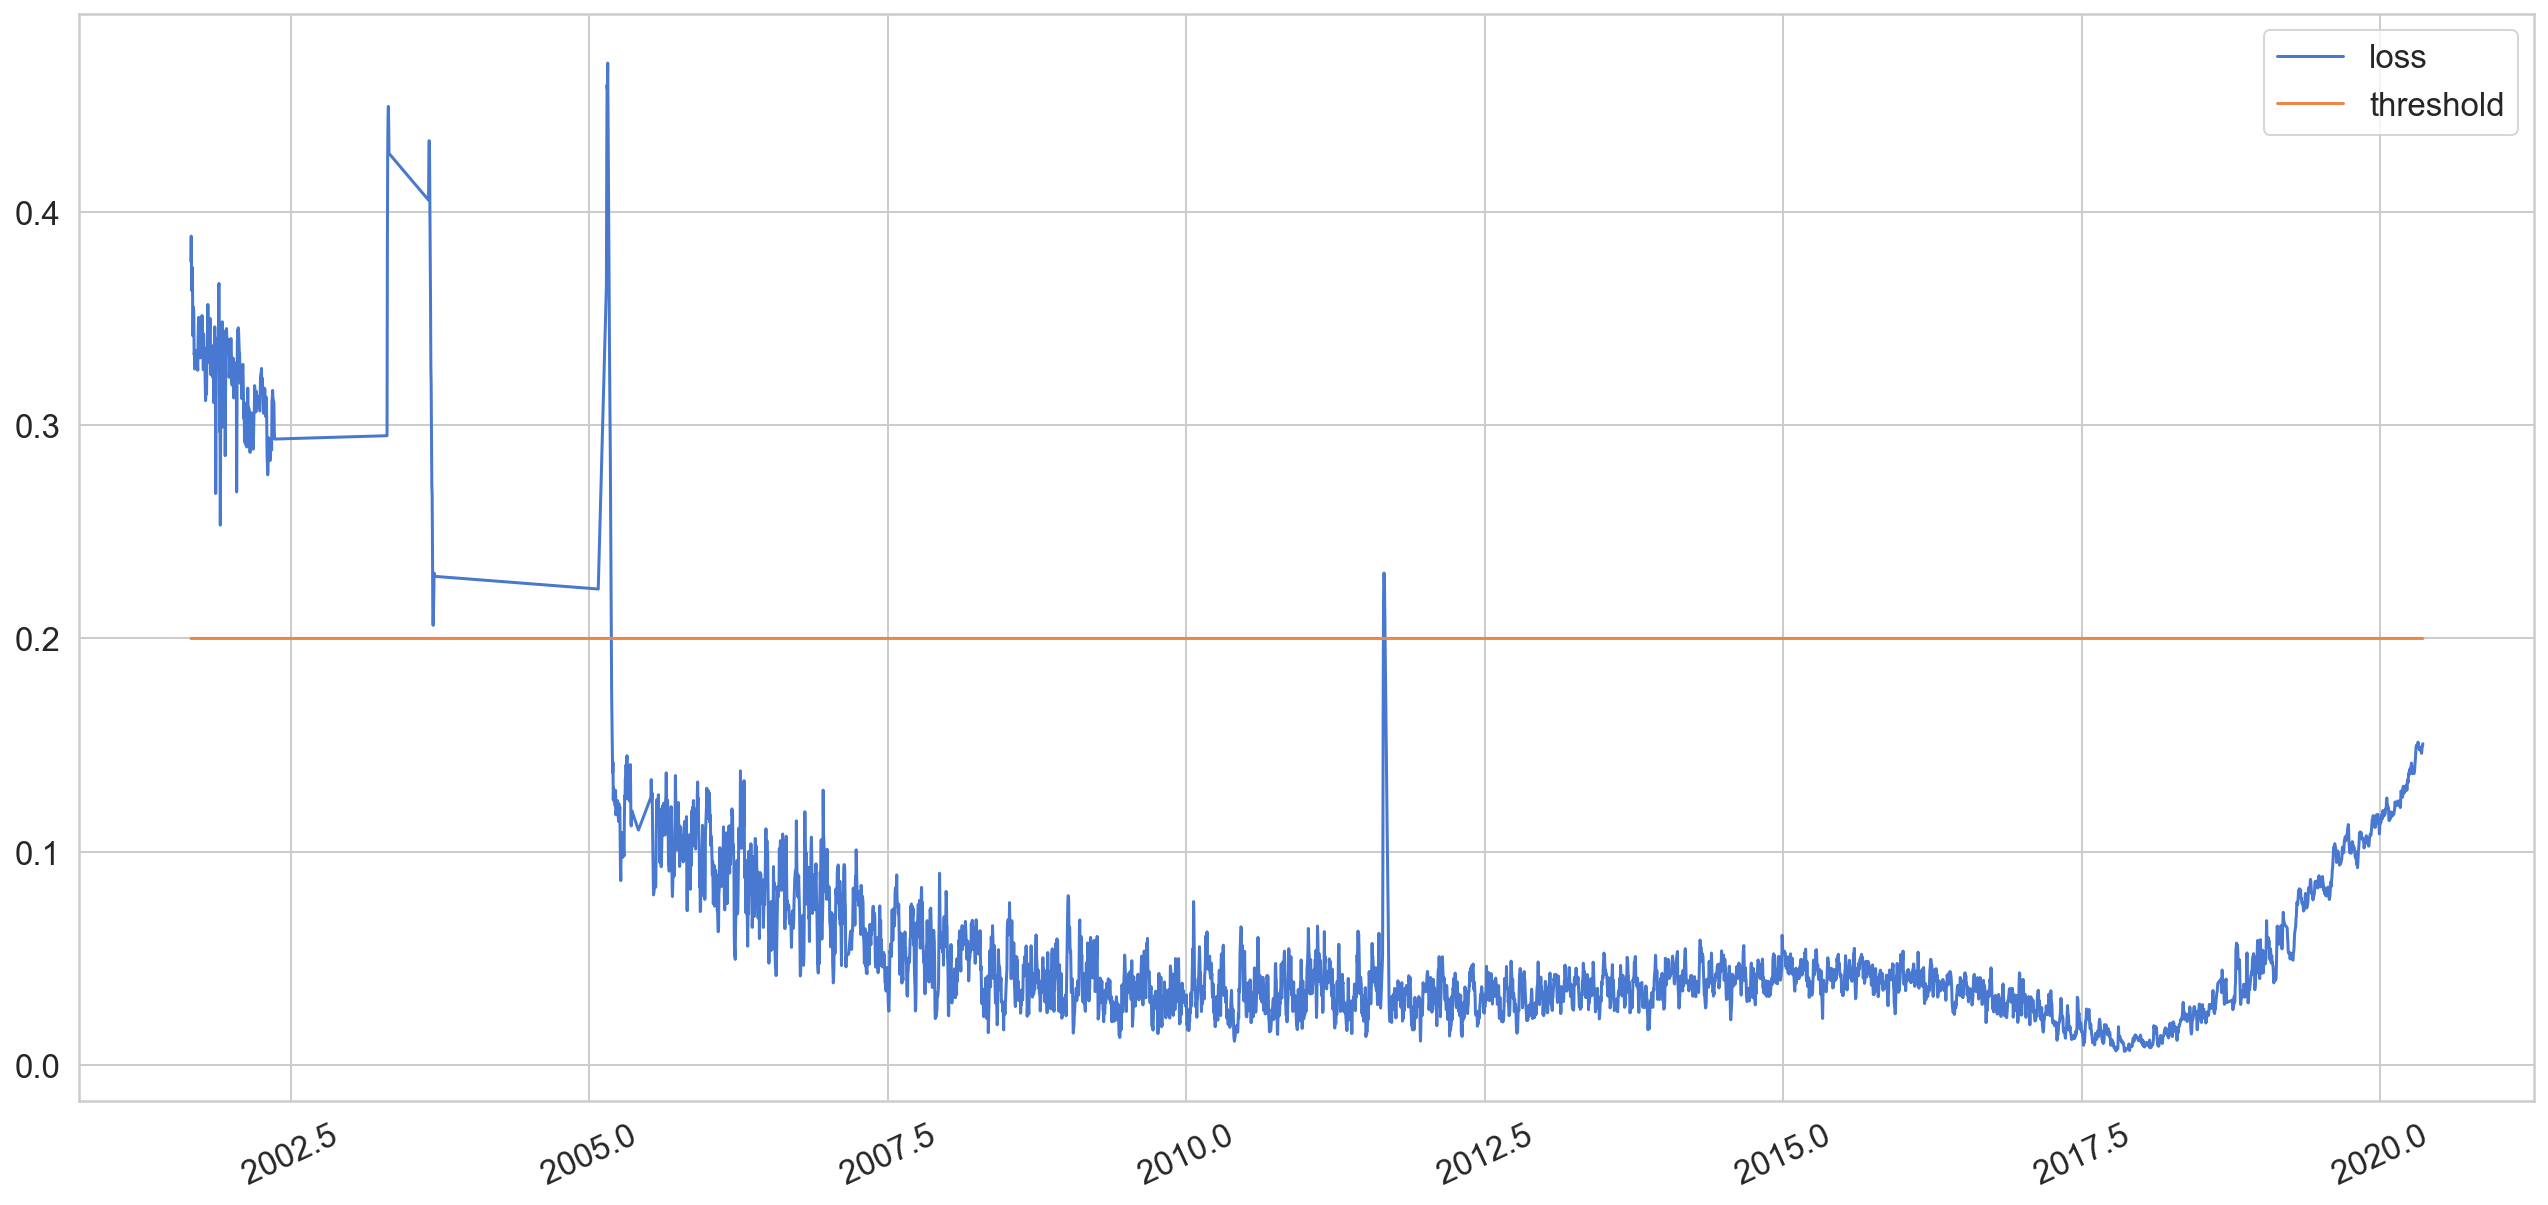

In [167]:
plt.plot(train_score_df.index, train_score_df.loss, label='loss')
plt.plot(train_score_df.index, train_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [168]:
train_anomalies = train_score_df[train_score_df.anomaly == True]
train_anomalies.head()

,loss,threshold,anomaly,un
date,,,,
2001.6646,0.376648,0.2,True,2.381934
2001.6674,0.388555,0.2,True,2.430381
2001.6701,0.371672,0.2,True,2.427157
2001.6728,0.362966,0.2,True,2.381281
2001.6756,0.374067,0.2,True,2.408057


/Users/nikilshyamsunder/miniforge3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


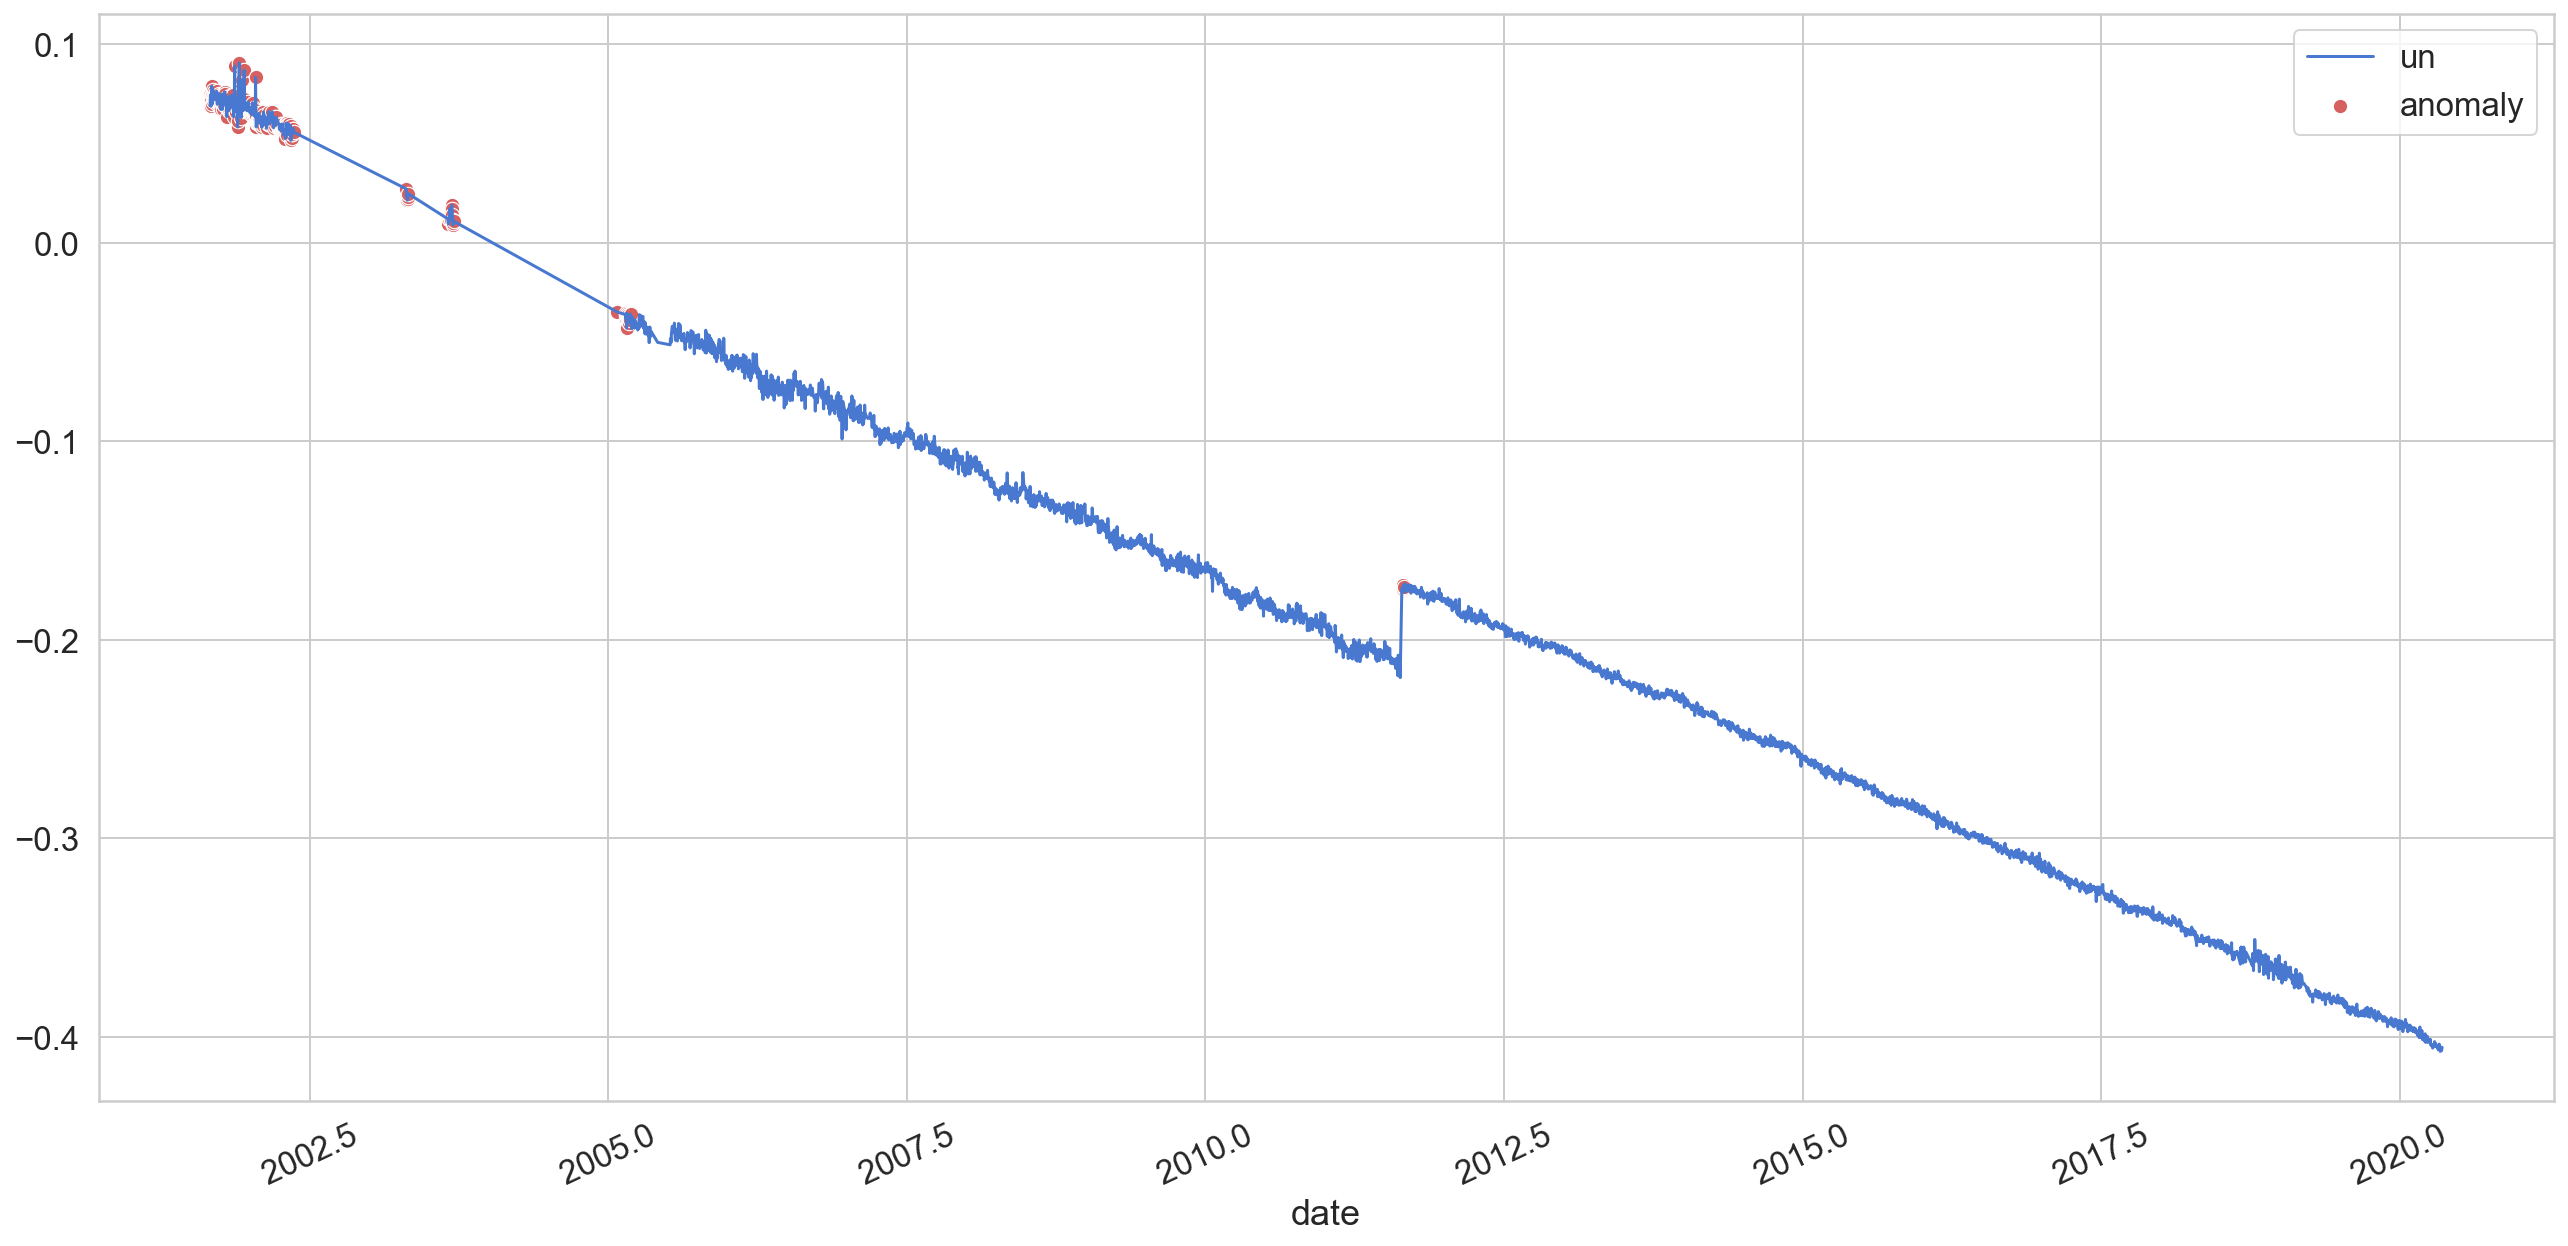

In [169]:
plt.plot(
  train.iloc[TIME_STEPS:].index, 
  scaler.inverse_transform(np.array(train.iloc[TIME_STEPS:].un).reshape(-1, 1)), 
  label='un'
);

sns.scatterplot(
  train_anomalies.index,
  scaler.inverse_transform(np.array(train_anomalies.iloc[:, 3]).reshape(-1,1)).reshape(-1),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

In [51]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

8/8 [==============================] - 0s 15ms/step


In [52]:
THRESHOLD = .35

test_score_df = pd.DataFrame(index=test.iloc[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['un'] = test[TIME_STEPS:].un

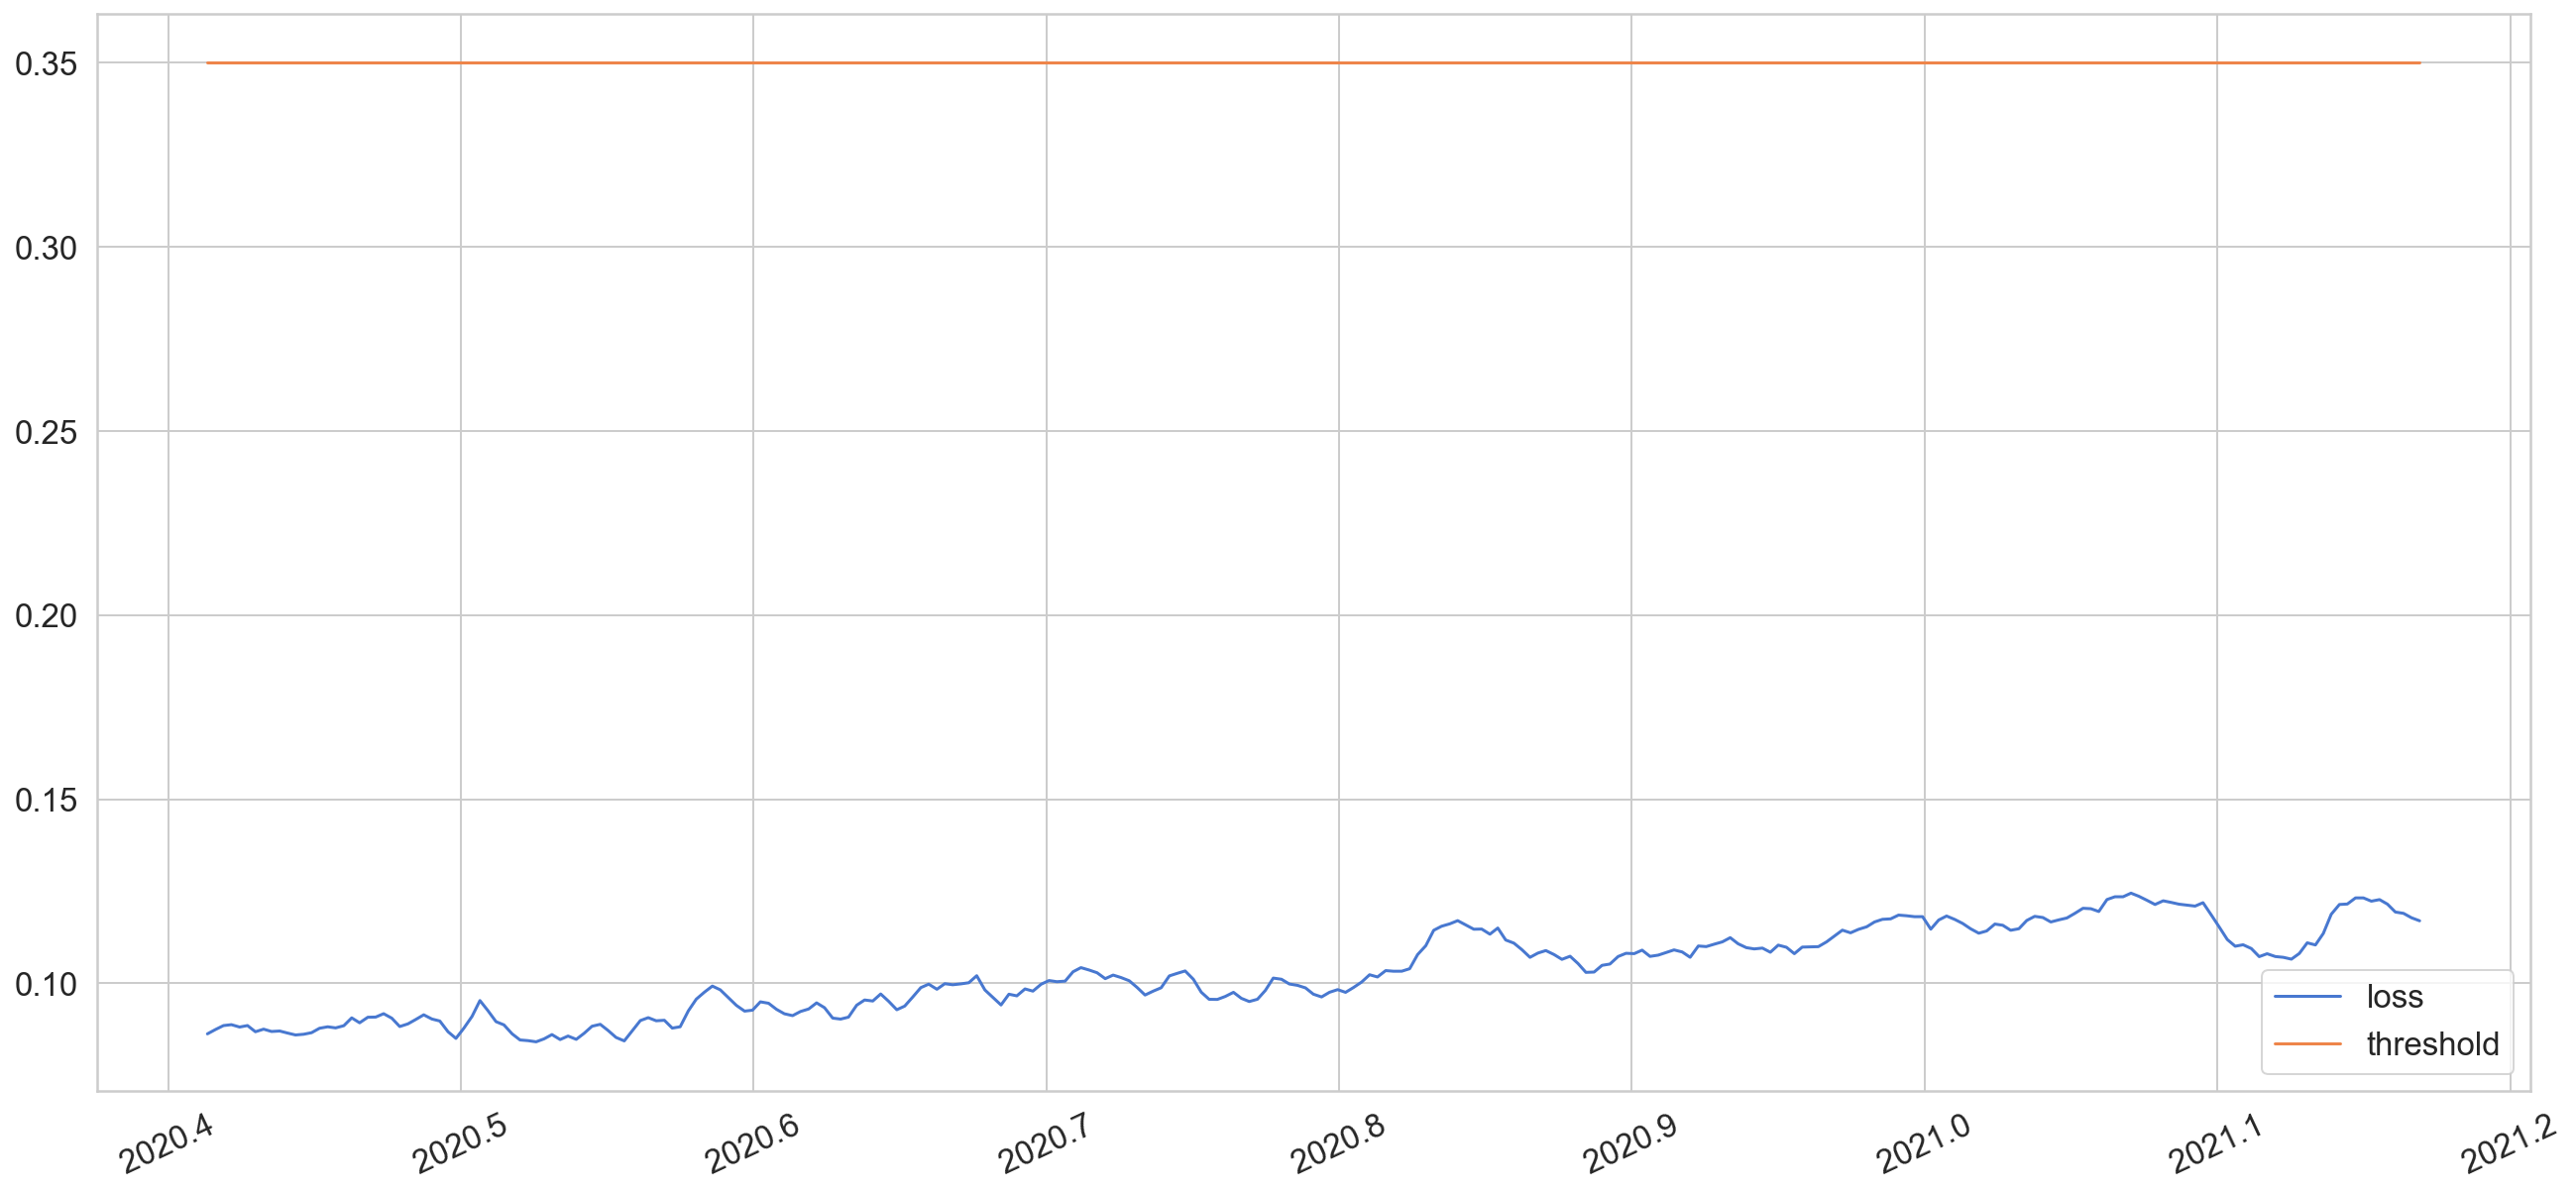

In [32]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [151]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2007.3566,0.35915,0.35,True,1.144323


/Users/nikilshyamsunder/miniforge3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


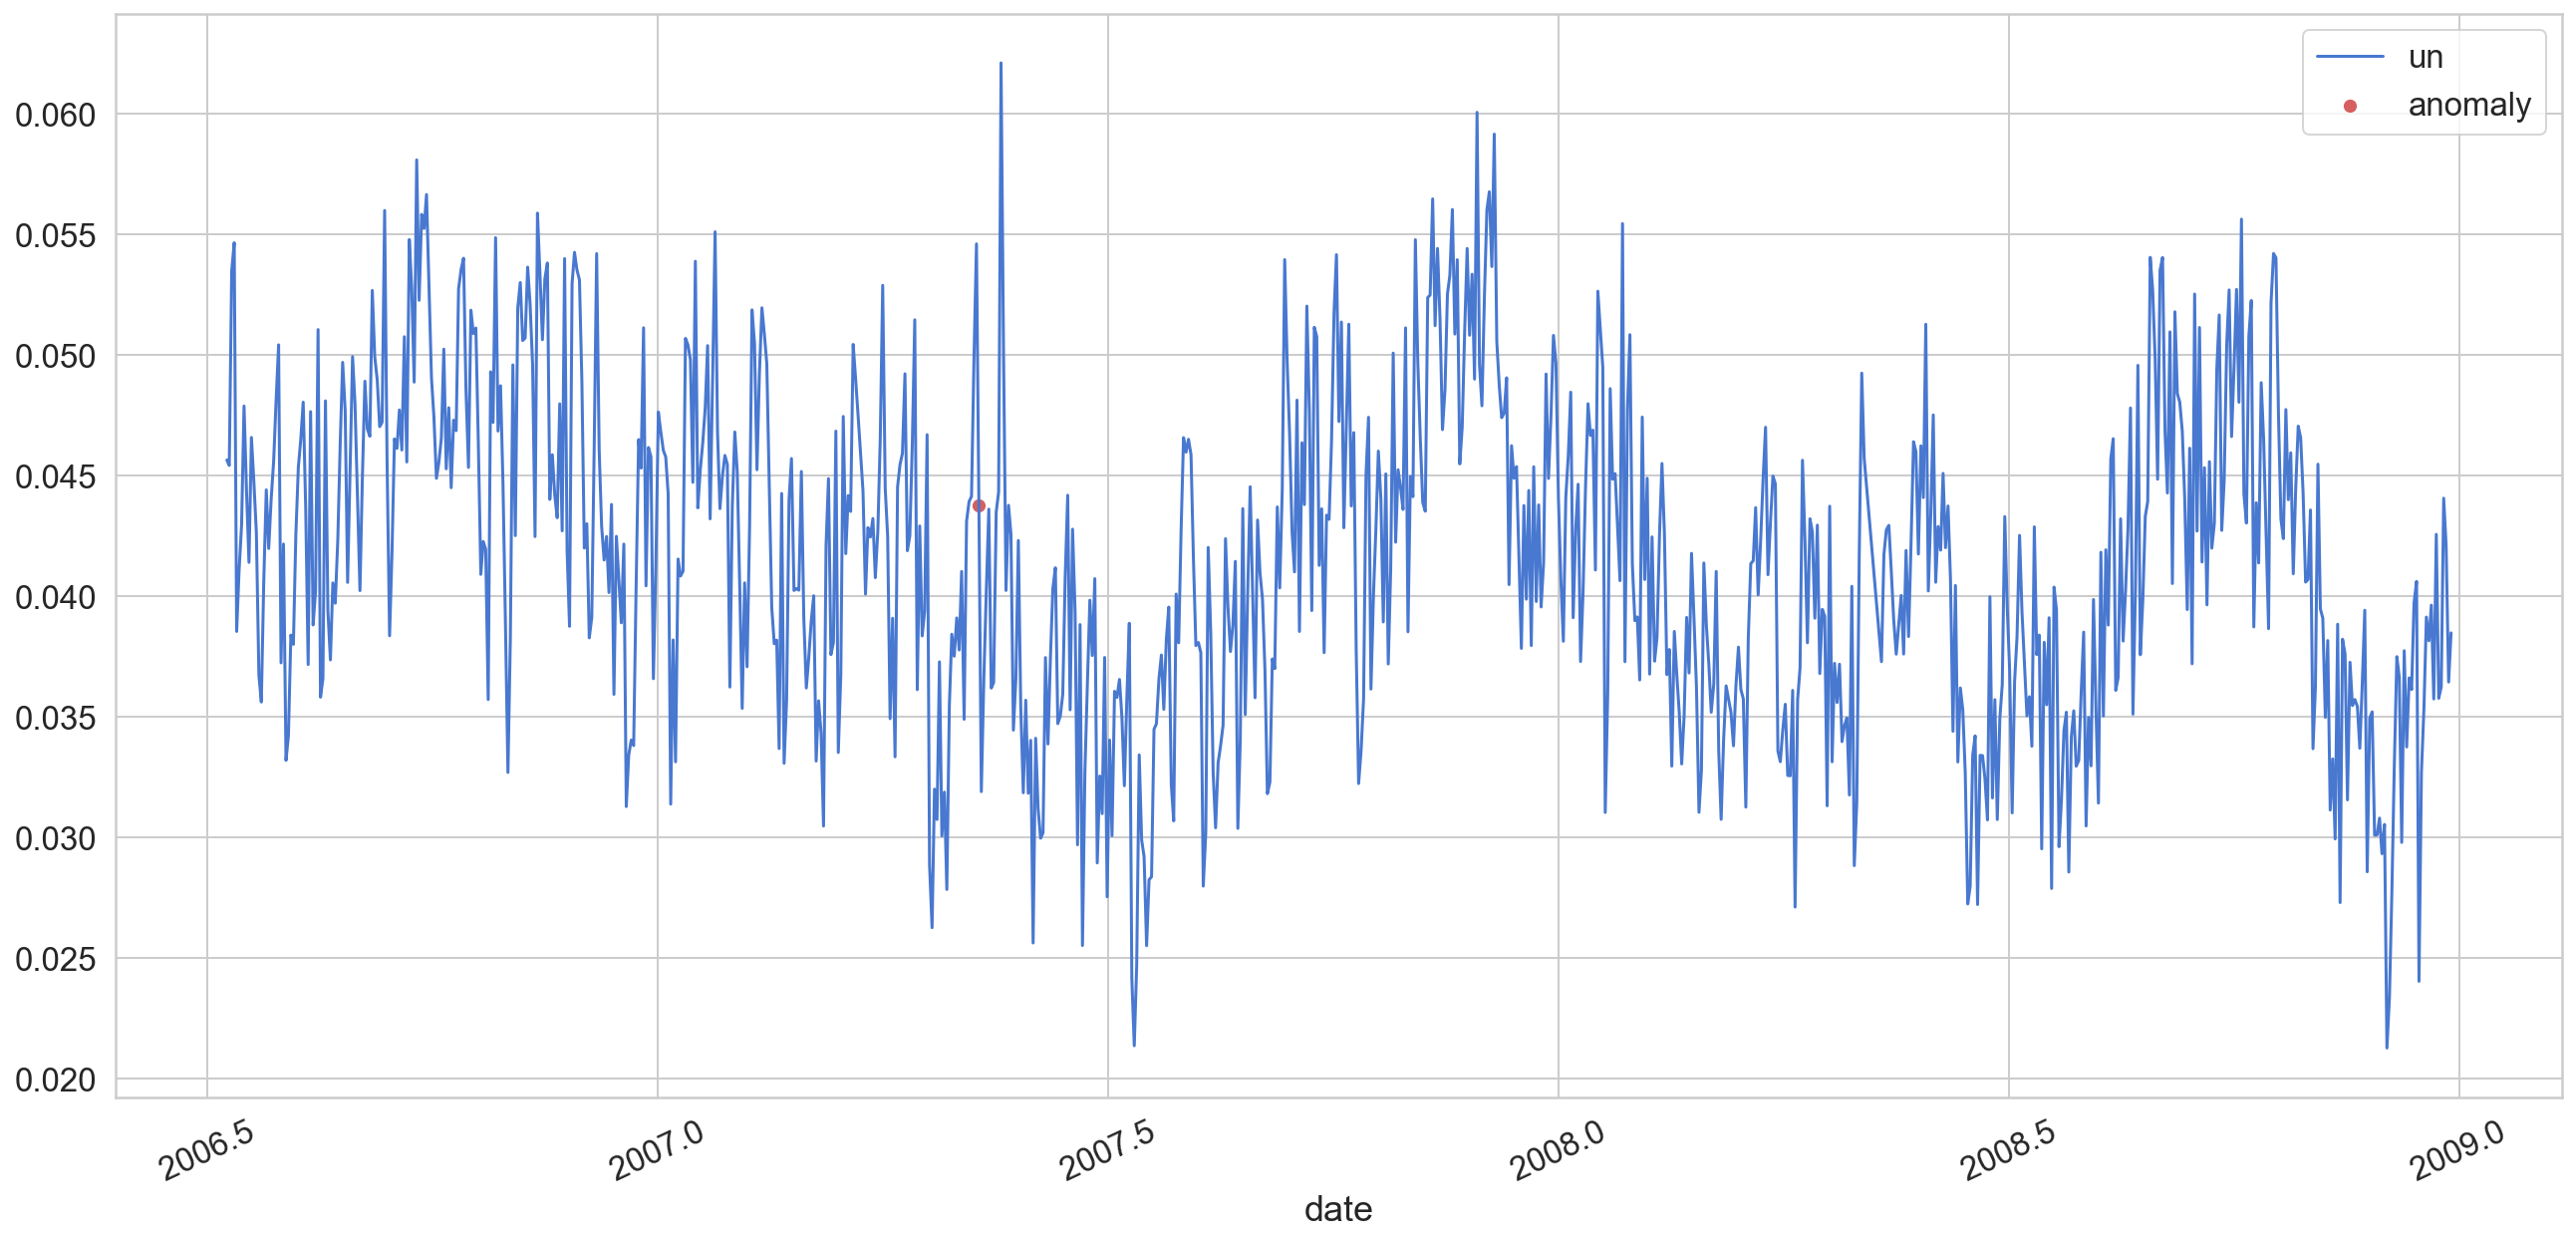

In [152]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(np.array(test[TIME_STEPS:].close).reshape(-1, 1)), 
  label='un'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(np.array(anomalies.iloc[:, 3]).reshape(-1,1)).reshape(-1),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();
